# Sequence To Sequence
- 한 시퀀스를 다른 시퀀스로 변환하는 작업을 수행하는 딥러닝 모델
- 주로 자연어 처리(NLP) 분야에서 활용
- 인코더(Encoder)와 디코더(Decoder)라는 모듈로 구성되어 “Encoder-Decoder 모델”이라고도 함
- 입력 길이와 출력 길이가 다른 경우 활용 (ex : 번역기, 텍스트 요약 등)
- 인코더와 디코더로 구성된 모형

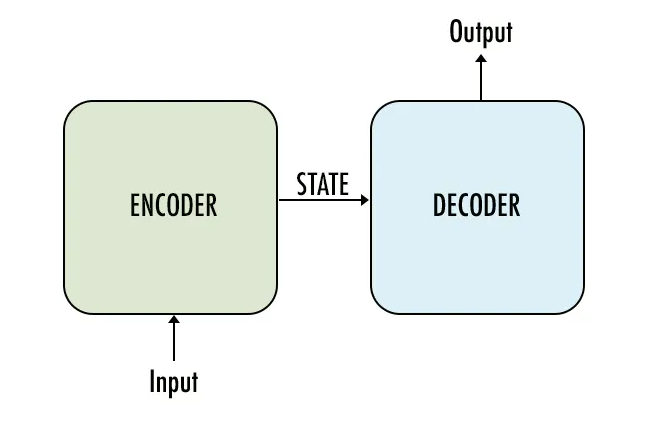

## Encoder
1. 매 시점(time step)원문의 단어(token)가 입력되면(단어의 임베딩이 입력되면) 인코더는 이를 이용해 은닉 상태를 업데이트
3. 입력 시퀀스의 끝까지 이 과정을 반복하면 인코더의 최종 은닉 상태는 입력 시퀀스의 정보를 압축 요약한 정보를 담고 있게 됨
4. 이 마지막 시점에서의 인코더 은닉 상태를 컨텍스트 벡터라고 하고, 이 값은 디코더로 넘어감

## Decoder
1. 디코더는 전달받은 컨텍스트 벡터로 자신의 은닉 상태를 초기화
2. 그리고 매 시점 자신이 바로 직전 시점에 출력했던 단어를 입력으로 받아, 자신의 은닉 상태를 업데이트하고, 이를 이용해 다음 단어를 예측
    - 최초 시점에서는 시퀀스 시작을 의미하는 `<sos>` 토큰(Start Of Sequence)을 입력으로 받는다.
3. 이 과정을 정해진 반복 횟수 또는 시퀀스 끝을 나타내는 `<eos>` 토큰(End Of Sequence)이 나올 때까지 수행

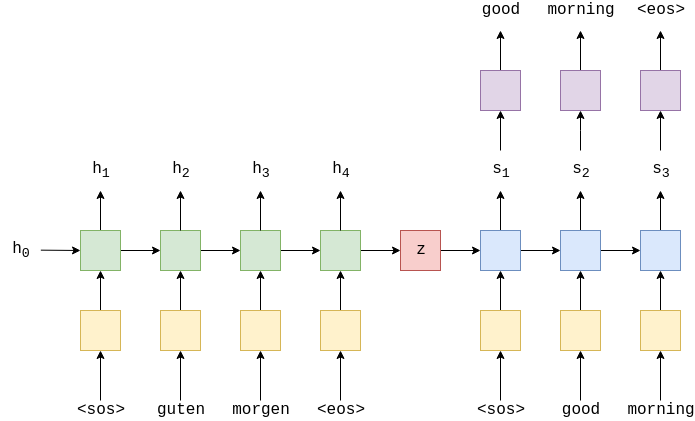

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import random
import os

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

DATA_PATH = os.getcwd()+'/data/en2ko/'
SEED = 42

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device,DATA_PATH

('cuda', 'c:\\study\\04_NLP/data/en2ko/')

# 번역: 한국어 -> 영어

In [2]:
train = pd.read_csv(f"{DATA_PATH}translate_en_ko.csv")
train.shape

(5794, 2)

In [3]:
train[['ko','en']]

,ko,en
0,이 제품들은 같은 품질이다.,These products are of the same quality.
1,미팅이 취소되었다.,The meeting was cancelled.
2,그들이 이것을 찾았다.,They found this.
3,톰은 메리에게 왜 그가 늦게까지 일해야 했는지 알려주지 않았다.,Tom didn't tell Mary why he had to work late.
4,먼저 가세요.,After you.
...,...,...
5789,일할 준비 됐니?,Are you ready to start working?
5790,"번거롭게 해 드려 죄송하지만, 저 좀 도와주시겠어요?","Sorry to trouble you, but can you help me?"
5791,방금 말씀하신 것을 다시 한번 말씀해 주시겠어요?,Could you please repeat what you just said?
5792,탐은 해양 생물학자가 되기 위해 공부하고 있다.,Tom is studying to become a marine biologist.


# 텍스트 정제
- 소스 데이터는 한국어
- 타겟 데이터는 영어

In [4]:
train["ko"] = train["ko"].str.replace("[^가-힣 0-9,.!?\"\']","", regex=True)
train["en"] = train["en"].str.replace("[^a-zA-Z 0-9,.!?\"\']","", regex=True).str.lower()

In [5]:
len("\t")

1

- sos 와 eos 토큰 붙여주기
    - sos 토큰: `\t`
    - eos 토큰: `\n`

In [6]:
train["en"] = "\t" + train["en"] + "\n" # 타겟 시퀀스에만 붙여 주면 된다.

In [7]:
train[['ko','en']]

,ko,en
0,이 제품들은 같은 품질이다.,\tthese products are of the same quality.\n
1,미팅이 취소되었다.,\tthe meeting was cancelled.\n
2,그들이 이것을 찾았다.,\tthey found this.\n
3,톰은 메리에게 왜 그가 늦게까지 일해야 했는지 알려주지 않았다.,\ttom didn't tell mary why he had to work late.\n
4,먼저 가세요.,\tafter you.\n
...,...,...
5789,일할 준비 됐니?,\tare you ready to start working?\n
5790,"번거롭게 해 드려 죄송하지만, 저 좀 도와주시겠어요?","\tsorry to trouble you, but can you help me?\n"
5791,방금 말씀하신 것을 다시 한번 말씀해 주시겠어요?,\tcould you please repeat what you just said?\n
5792,탐은 해양 생물학자가 되기 위해 공부하고 있다.,\ttom is studying to become a marine biologist.\n


# 한국어 어휘집 만들기

In [8]:
tmp = " ".join(train["ko"].tolist()) # 모든 샘플 하나의 문자열로 연결

In [9]:
tmp = sorted(set(tmp)) # 중복 제거후 정렬
len(tmp), type(tmp)

(976, list)

In [10]:
tmp # 소스데이터의 한국어 단어 갯수

[' ',
 '!',
 '"',
 ',',
 '.',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '?',
 '가',
 '각',
 '간',
 '갇',
 '갈',
 '감',
 '갑',
 '값',
 '갔',
 '강',
 '갖',
 '같',
 '갛',
 '개',
 '객',
 '갰',
 '걀',
 '걔',
 '거',
 '걱',
 '건',
 '걷',
 '걸',
 '검',
 '겁',
 '것',
 '겉',
 '게',
 '겐',
 '겠',
 '겨',
 '격',
 '겪',
 '견',
 '결',
 '겼',
 '경',
 '곁',
 '계',
 '고',
 '곡',
 '곤',
 '곧',
 '골',
 '곰',
 '곱',
 '곳',
 '공',
 '과',
 '관',
 '광',
 '괜',
 '괴',
 '굉',
 '교',
 '구',
 '국',
 '군',
 '굳',
 '굴',
 '굶',
 '굼',
 '굽',
 '궁',
 '궈',
 '권',
 '궤',
 '귀',
 '귄',
 '귓',
 '규',
 '그',
 '극',
 '근',
 '글',
 '금',
 '급',
 '긋',
 '긍',
 '기',
 '긴',
 '길',
 '김',
 '깁',
 '깊',
 '까',
 '깎',
 '깐',
 '깔',
 '깜',
 '깡',
 '깨',
 '깰',
 '꺼',
 '꺾',
 '껍',
 '껏',
 '껐',
 '께',
 '껴',
 '꼈',
 '꼬',
 '꼭',
 '꼴',
 '꼼',
 '꽃',
 '꽉',
 '꽤',
 '꾸',
 '꾼',
 '꿀',
 '꿇',
 '꿈',
 '꿍',
 '꿔',
 '꿨',
 '뀌',
 '끄',
 '끈',
 '끊',
 '끌',
 '끓',
 '끔',
 '끗',
 '끙',
 '끝',
 '끼',
 '낀',
 '낄',
 '낌',
 '나',
 '낙',
 '낚',
 '난',
 '날',
 '낡',
 '남',
 '납',
 '낫',
 '났',
 '낭',
 '낮',
 '낯',
 '내',
 '낸',
 '낼',
 '냄',
 '냈',
 '냉',
 '냐',
 '냥'

- 문자번호 to 문자

In [11]:
id2char_ko = dict(enumerate(tmp,2)) # 0번은 <pad>, 1번은 <unk> 을 위해 단어번호는 2부터 시작

In [12]:
id2char_ko[0] = "<pad>"
id2char_ko[1] = "<unk>"

In [13]:
id2char_ko

{2: ' ',
 3: '!',
 4: '"',
 5: ',',
 6: '.',
 7: '0',
 8: '1',
 9: '2',
 10: '3',
 11: '4',
 12: '5',
 13: '6',
 14: '7',
 15: '8',
 16: '9',
 17: '?',
 18: '가',
 19: '각',
 20: '간',
 21: '갇',
 22: '갈',
 23: '감',
 24: '갑',
 25: '값',
 26: '갔',
 27: '강',
 28: '갖',
 29: '같',
 30: '갛',
 31: '개',
 32: '객',
 33: '갰',
 34: '걀',
 35: '걔',
 36: '거',
 37: '걱',
 38: '건',
 39: '걷',
 40: '걸',
 41: '검',
 42: '겁',
 43: '것',
 44: '겉',
 45: '게',
 46: '겐',
 47: '겠',
 48: '겨',
 49: '격',
 50: '겪',
 51: '견',
 52: '결',
 53: '겼',
 54: '경',
 55: '곁',
 56: '계',
 57: '고',
 58: '곡',
 59: '곤',
 60: '곧',
 61: '골',
 62: '곰',
 63: '곱',
 64: '곳',
 65: '공',
 66: '과',
 67: '관',
 68: '광',
 69: '괜',
 70: '괴',
 71: '굉',
 72: '교',
 73: '구',
 74: '국',
 75: '군',
 76: '굳',
 77: '굴',
 78: '굶',
 79: '굼',
 80: '굽',
 81: '궁',
 82: '궈',
 83: '권',
 84: '궤',
 85: '귀',
 86: '귄',
 87: '귓',
 88: '규',
 89: '그',
 90: '극',
 91: '근',
 92: '글',
 93: '금',
 94: '급',
 95: '긋',
 96: '긍',
 97: '기',
 98: '긴',
 99: '길',
 100: '김',
 101: '깁',
 102: 

- 문자 to 문자번호

In [14]:
char2id_ko = { v:k for k,v in id2char_ko.items() }

In [15]:
char2id_ko["<unk>"]

1

In [16]:
char2id_ko

{' ': 2,
 '!': 3,
 '"': 4,
 ',': 5,
 '.': 6,
 '0': 7,
 '1': 8,
 '2': 9,
 '3': 10,
 '4': 11,
 '5': 12,
 '6': 13,
 '7': 14,
 '8': 15,
 '9': 16,
 '?': 17,
 '가': 18,
 '각': 19,
 '간': 20,
 '갇': 21,
 '갈': 22,
 '감': 23,
 '갑': 24,
 '값': 25,
 '갔': 26,
 '강': 27,
 '갖': 28,
 '같': 29,
 '갛': 30,
 '개': 31,
 '객': 32,
 '갰': 33,
 '걀': 34,
 '걔': 35,
 '거': 36,
 '걱': 37,
 '건': 38,
 '걷': 39,
 '걸': 40,
 '검': 41,
 '겁': 42,
 '것': 43,
 '겉': 44,
 '게': 45,
 '겐': 46,
 '겠': 47,
 '겨': 48,
 '격': 49,
 '겪': 50,
 '견': 51,
 '결': 52,
 '겼': 53,
 '경': 54,
 '곁': 55,
 '계': 56,
 '고': 57,
 '곡': 58,
 '곤': 59,
 '곧': 60,
 '골': 61,
 '곰': 62,
 '곱': 63,
 '곳': 64,
 '공': 65,
 '과': 66,
 '관': 67,
 '광': 68,
 '괜': 69,
 '괴': 70,
 '굉': 71,
 '교': 72,
 '구': 73,
 '국': 74,
 '군': 75,
 '굳': 76,
 '굴': 77,
 '굶': 78,
 '굼': 79,
 '굽': 80,
 '궁': 81,
 '궈': 82,
 '권': 83,
 '궤': 84,
 '귀': 85,
 '귄': 86,
 '귓': 87,
 '규': 88,
 '그': 89,
 '극': 90,
 '근': 91,
 '글': 92,
 '금': 93,
 '급': 94,
 '긋': 95,
 '긍': 96,
 '기': 97,
 '긴': 98,
 '길': 99,
 '김': 100,
 '깁': 101,
 '깊': 

# 영어 어휘집 만들기

In [17]:
tmp = " ".join(train["en"].tolist()) # 모든 샘플 하나의 문자열로 연결
tmp = sorted(set(tmp)) # 중복 제거후 정렬
len(tmp), type(tmp)

(45, list)

In [18]:
id2char_en = dict(enumerate(tmp,2)) # 0번은 <pad>, 1번은 <unk> 을 위해 단어번호는 2부터 시작
id2char_en[0] = "<pad>"
id2char_en[1] = "<unk>"

In [19]:
id2char_en

{2: '\t',
 3: '\n',
 4: ' ',
 5: '!',
 6: '"',
 7: "'",
 8: ',',
 9: '.',
 10: '0',
 11: '1',
 12: '2',
 13: '3',
 14: '4',
 15: '5',
 16: '6',
 17: '7',
 18: '8',
 19: '9',
 20: '?',
 21: 'a',
 22: 'b',
 23: 'c',
 24: 'd',
 25: 'e',
 26: 'f',
 27: 'g',
 28: 'h',
 29: 'i',
 30: 'j',
 31: 'k',
 32: 'l',
 33: 'm',
 34: 'n',
 35: 'o',
 36: 'p',
 37: 'q',
 38: 'r',
 39: 's',
 40: 't',
 41: 'u',
 42: 'v',
 43: 'w',
 44: 'x',
 45: 'y',
 46: 'z',
 0: '<pad>',
 1: '<unk>'}

In [20]:
char2id_en = { v:k for k,v in id2char_en.items() }

In [21]:
char2id_en["\t"] # sos 토큰

2

In [22]:
char2id_en["\n"] # eos 토큰

3

In [23]:
char2id_en

{'\t': 2,
 '\n': 3,
 ' ': 4,
 '!': 5,
 '"': 6,
 "'": 7,
 ',': 8,
 '.': 9,
 '0': 10,
 '1': 11,
 '2': 12,
 '3': 13,
 '4': 14,
 '5': 15,
 '6': 16,
 '7': 17,
 '8': 18,
 '9': 19,
 '?': 20,
 'a': 21,
 'b': 22,
 'c': 23,
 'd': 24,
 'e': 25,
 'f': 26,
 'g': 27,
 'h': 28,
 'i': 29,
 'j': 30,
 'k': 31,
 'l': 32,
 'm': 33,
 'n': 34,
 'o': 35,
 'p': 36,
 'q': 37,
 'r': 38,
 's': 39,
 't': 40,
 'u': 41,
 'v': 42,
 'w': 43,
 'x': 44,
 'y': 45,
 'z': 46,
 '<pad>': 0,
 '<unk>': 1}

# 토큰화
- 문자단위로 토큰화 하면서 정수번호 부여까지

In [24]:
text = train["ko"][0]
def tokenizer(text, char2id):  # 문자열과 단어번호 부여하는 딕셔너리 전달 받기
    return [ char2id[c] for c in text]

In [25]:
tokenizer(text, char2id_ko)

[666, 2, 699, 902, 264, 660, 2, 29, 660, 2, 902, 731, 666, 215, 6]

In [26]:
src_data = [ tokenizer(text, char2id_ko) for text in train["ko"] ] # 한국어, 소스 시퀀스
trg_data = [ tokenizer(text, char2id_en) for text in train["en"] ] # 영어, 소스 시퀀스

In [27]:
len(src_data), len(trg_data)

(5794, 5794)

# 데이터셋 클래스

In [28]:
class TranslateDataset(torch.utils.data.Dataset):
    def __init__(self, src, trg):
        self.src = src
        self.trg = trg

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        item = {}
        item["src"] = torch.tensor(self.src[idx]) # 임베딩으로 넣을 것이기에 다음 tensor를 사용함.
        item["trg"] = torch.tensor(self.trg[idx]) # 임베딩으로 넣을 것이기에 다음 tesnor를 사용함.
        return item

In [29]:
x = [ torch.tensor(lst) for lst in src_data[:2]]
x

[tensor([666,   2, 699, 902, 264, 660,   2,  29, 660,   2, 902, 731, 666, 215,
           6]),
 tensor([407, 872, 666,   2, 793, 523, 246, 606, 215,   6])]

In [30]:
dt = TranslateDataset(src_data, trg_data)
dl = torch.utils.data.DataLoader(dt, batch_size=2, shuffle=False)
batch = next(iter(dl))
batch 

# 다음 배치단위의 소스한국어 데이터와 타켓 영어 데이터의 길이가 달라서 오류가 나온다.

RuntimeError: stack expects each tensor to be equal size, but got [15] at entry 0 and [10] at entry 1

- torch.nn.utils.rnn.pad_sequence
    - 첫번째 인수로 정수번호로 이루어진 1차원 텐서들을 담은 리스트 전달
    - batch_first 에 True 를 주면 된다.
    - padding_value 파라미터는 기본값이 0 이다.

In [30]:
torch.nn.utils.rnn.pad_sequence(x, batch_first=True)

tensor([[666,   2, 699, 902, 264, 660,   2,  29, 660,   2, 902, 731, 666, 215,
           6],
        [407, 872, 666,   2, 793, 523, 246, 606, 215,   6,   0,   0,   0,   0,
           0]])

- DataLoarder 클래스의 collate_fn 파라미터
    - 배치 단위로 텐서로 변환해주는 콜백함수를 전달하면 된다.

In [31]:
def collate_fn(lst):

    # print(lst)

    src = [ item["src"] for item in lst]
    src = torch.nn.utils.rnn.pad_sequence(src, batch_first=True)

    trg = [ item["trg"] for item in lst]
    trg = torch.nn.utils.rnn.pad_sequence(trg, batch_first=True)

    return {"src": src, "trg": trg}

# 데이터로더에 들어오는 소스데이터와 타켓데이터를 다음과 같이 패딩을 자동화 해줌

In [33]:
dt = TranslateDataset(src_data, trg_data)
dl = torch.utils.data.DataLoader(dt, batch_size=2, shuffle=False, collate_fn= collate_fn)
batch = next(iter(dl))
batch

[{'src': tensor([666,   2, 699, 902, 264, 660,   2,  29, 660,   2, 902, 731, 666, 215,
          6]), 'trg': tensor([ 2, 40, 28, 25, 39, 25,  4, 36, 38, 35, 24, 41, 23, 40, 39,  4, 21, 38,
        25,  4, 35, 26,  4, 40, 28, 25,  4, 39, 21, 33, 25,  4, 37, 41, 21, 32,
        29, 40, 45,  9,  3])}, {'src': tensor([407, 872, 666,   2, 793, 523, 246, 606, 215,   6]), 'trg': tensor([ 2, 40, 28, 25,  4, 33, 25, 25, 40, 29, 34, 27,  4, 43, 21, 39,  4, 23,
        21, 34, 23, 25, 32, 32, 25, 24,  9,  3])}]


{'src': tensor([[666,   2, 699, 902, 264, 660,   2,  29, 660,   2, 902, 731, 666, 215,
            6],
         [407, 872, 666,   2, 793, 523, 246, 606, 215,   6,   0,   0,   0,   0,
            0]]),
 'trg': tensor([[ 2, 40, 28, 25, 39, 25,  4, 36, 38, 35, 24, 41, 23, 40, 39,  4, 21, 38,
          25,  4, 35, 26,  4, 40, 28, 25,  4, 39, 21, 33, 25,  4, 37, 41, 21, 32,
          29, 40, 45,  9,  3],
         [ 2, 40, 28, 25,  4, 33, 25, 25, 40, 29, 34, 27,  4, 43, 21, 39,  4, 23,
          21, 34, 23, 25, 32, 32, 25, 24,  9,  3,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0]])}

# Encoder layer

In [32]:
class Encoder(torch.nn.Module):
    def __init__(self, num_embeddings, embedding_dim): # 어휘집 크기, 임베딩벡터 크기
        super().__init__()
        self.emb_layer = torch.nn.Embedding(num_embeddings, embedding_dim)
        self.rnn_layer = torch.nn.LSTM(embedding_dim, embedding_dim*2, batch_first=True)

    def forward(self, x): # src 텐서가 전달
        x = self.emb_layer(x) # batch, seq, features

        # outputs: batch, seq, features
        # hn: nlayer, batch, features
        # cn: nlayer, batch, features
        outputs, (hn, cn) = self.rnn_layer(x)

        return hn, cn

In [34]:
dt = TranslateDataset(src_data, trg_data)
dl = torch.utils.data.DataLoader(dt, batch_size=2, shuffle=False, collate_fn= collate_fn)
batch = next(iter(dl))
batch

{'src': tensor([[666,   2, 699, 902, 264, 660,   2,  29, 660,   2, 902, 731, 666, 215,
            6],
         [407, 872, 666,   2, 793, 523, 246, 606, 215,   6,   0,   0,   0,   0,
            0]]),
 'trg': tensor([[ 2, 40, 28, 25, 39, 25,  4, 36, 38, 35, 24, 41, 23, 40, 39,  4, 21, 38,
          25,  4, 35, 26,  4, 40, 28, 25,  4, 39, 21, 33, 25,  4, 37, 41, 21, 32,
          29, 40, 45,  9,  3],
         [ 2, 40, 28, 25,  4, 33, 25, 25, 40, 29, 34, 27,  4, 43, 21, 39,  4, 23,
          21, 34, 23, 25, 32, 32, 25, 24,  9,  3,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0]])}

In [35]:
encoder = Encoder(len(char2id_ko), 64)
hn, cn = encoder(batch["src"])
hn.shape, cn.shape

(torch.Size([1, 2, 128]), torch.Size([1, 2, 128]))

# Decoder layer

In [36]:
class Decoder(torch.nn.Module):
    def __init__(self, num_embeddings, embedding_dim): # 어휘집 크기, 임베딩 벡터크기
        super().__init__()
        self.emb_layer = torch.nn.Embedding(num_embeddings, embedding_dim)
        # 디코더에 출력 히든 크기는 인코더에서 전달받은 히든과 셀스테이트의 피처 크기와 같아야 한다.
        
        self.rnn_layer = torch.nn.LSTM(embedding_dim, embedding_dim*2 , batch_first=True)

        self.fc_layer = torch.nn.Linear(embedding_dim*2, num_embeddings) # 단어 예측하는 layer

    def forward(self, x, hn, cn): # x 텐서: 하나의 시점에 해당하는 단어 텐서가 입력으로 전달됨.
        x = self.emb_layer(x) # b, 1 , f , 다음 처음 들어갈 단어는 시작을 알리는 스타트 토큰이 1번으로 들어감.


        # outputs: batch, 1, feature
        # hn : nlayer , batch, feature
        # cn : nlayer , batch, feature
        outputs, (hn, cn) = self.rnn_layer(x,(hn, cn)) # 여기에서 맨처음 hn,cn은 인코더에서 받은 정보임,

        pred = self.fc_layer(hn[-1]) # hn[-1]에 의미는: nlayer , batch, feature -> batch, feature

        return pred, hn, cn

In [37]:
batch["trg"]

tensor([[ 2, 40, 28, 25, 39, 25,  4, 36, 38, 35, 24, 41, 23, 40, 39,  4, 21, 38,
         25,  4, 35, 26,  4, 40, 28, 25,  4, 39, 21, 33, 25,  4, 37, 41, 21, 32,
         29, 40, 45,  9,  3],
        [ 2, 40, 28, 25,  4, 33, 25, 25, 40, 29, 34, 27,  4, 43, 21, 39,  4, 23,
         21, 34, 23, 25, 32, 32, 25, 24,  9,  3,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0]])

In [38]:
batch["trg"].shape # batch, seq

torch.Size([2, 41])

In [39]:
id2char_en

{2: '\t',
 3: '\n',
 4: ' ',
 5: '!',
 6: '"',
 7: "'",
 8: ',',
 9: '.',
 10: '0',
 11: '1',
 12: '2',
 13: '3',
 14: '4',
 15: '5',
 16: '6',
 17: '7',
 18: '8',
 19: '9',
 20: '?',
 21: 'a',
 22: 'b',
 23: 'c',
 24: 'd',
 25: 'e',
 26: 'f',
 27: 'g',
 28: 'h',
 29: 'i',
 30: 'j',
 31: 'k',
 32: 'l',
 33: 'm',
 34: 'n',
 35: 'o',
 36: 'p',
 37: 'q',
 38: 'r',
 39: 's',
 40: 't',
 41: 'u',
 42: 'v',
 43: 'w',
 44: 'x',
 45: 'y',
 46: 'z',
 0: '<pad>',
 1: '<unk>'}

In [40]:
print(f"스타트 토큰의 넘버: {repr(id2char_en[2])}, 엔드 토큰의 넘버: {repr(id2char_en[3])}")


스타트 토큰의 넘버: '\t', 엔드 토큰의 넘버: '\n'


In [41]:
batch["trg"][:],len(batch["trg"][0]) # 다음 처음값과 끝값이 각각 2,3임을 알 수가 있음.

(tensor([[ 2, 40, 28, 25, 39, 25,  4, 36, 38, 35, 24, 41, 23, 40, 39,  4, 21, 38,
          25,  4, 35, 26,  4, 40, 28, 25,  4, 39, 21, 33, 25,  4, 37, 41, 21, 32,
          29, 40, 45,  9,  3],
         [ 2, 40, 28, 25,  4, 33, 25, 25, 40, 29, 34, 27,  4, 43, 21, 39,  4, 23,
          21, 34, 23, 25, 32, 32, 25, 24,  9,  3,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0]]),
 41)

In [42]:
batch["trg"][:,0]

tensor([2, 2])

In [43]:
batch["trg"][:,0].view(-1,1) 
# 인덱싱할 경우 batch 차원만 남기 때문에 seq 차원을 추가해서 임베딩 레이어에 전달해야한다.
# 각 배치의 첫번째 스타트 토큰을 넣어주기 위함.

tensor([[2],
        [2]])

In [44]:
decoer = Decoder(len(char2id_en), 64)
pred, hn, cn = decoer(batch["trg"][:,0].view(-1,1), hn, cn) # hn, cn은 인코더가 전해주는 값임
pred.shape # t시점의 47개 단어의 예측값

torch.Size([2, 47])

In [45]:
len(id2char_en)

47

In [46]:
pred # 다음 결과 값은 모든 영어단어의 확률값임.

tensor([[ 0.0475,  0.0236,  0.0369,  0.0642,  0.0881, -0.0845, -0.0072, -0.0605,
          0.1519, -0.0945,  0.0948, -0.0005,  0.0896,  0.0284, -0.0183,  0.0199,
         -0.0102, -0.0158, -0.0251,  0.0241, -0.1018,  0.0742, -0.1633, -0.0612,
         -0.0143, -0.1231,  0.0536,  0.0784, -0.0334,  0.0245,  0.0756, -0.0064,
         -0.0734,  0.0847,  0.0582, -0.0548, -0.1295, -0.0135, -0.0300, -0.0487,
          0.0094, -0.0557,  0.0824, -0.0591, -0.0986,  0.0243,  0.0474],
        [ 0.0409,  0.0045, -0.0266,  0.0583,  0.0208, -0.0316,  0.0652, -0.0794,
          0.1309, -0.1724,  0.0889, -0.0110,  0.1229,  0.0439, -0.0767,  0.0314,
          0.0535, -0.0344, -0.0335, -0.1068, -0.0740,  0.0678, -0.1697, -0.0527,
          0.0142, -0.0455,  0.0315,  0.0449, -0.0260,  0.1396,  0.1179,  0.0423,
          0.0425,  0.0161,  0.1028, -0.0495, -0.1380, -0.0453, -0.0650, -0.0572,
          0.1511, -0.0010,  0.0876,  0.0032, -0.0903, -0.0018, -0.0807]],
       grad_fn=<AddmmBackward0>)

In [47]:
pred.argmax(axis=1)

tensor([ 8, 40])

In [50]:
pred.argmax(1).view(-1,1) 

tensor([[ 8],
        [40]])

In [48]:
pred[0,18], pred[1,44]# 다음 단어로 가장 확률이 높은 단어를 택

(tensor(-0.0251, grad_fn=<SelectBackward0>),
 tensor(-0.0903, grad_fn=<SelectBackward0>))

In [49]:
id2char_en[8],id2char_en[40] # 이부분은 47번 셀 결과값을 입력해줄 것

('8', 'x')

# Seq2Seq 모델
- 교사 강요
    - seq2seq 모델에서 이전 시점의 실제값을 현재 시점에 입력값으로 전달하는 방식

In [51]:
class Net(torch.nn.Module):
    def __init__(self, vocab_size_src, vocab_size_trg, embedding_dim = 64, device = "cpu"):
        super().__init__()
        self.encoder = Encoder(vocab_size_src, embedding_dim) 
        # vocab_size_src는 한국어 단어의 총 갯수
        self.decoder = Decoder(vocab_size_trg, embedding_dim)
        # vocab_size_trg는 한국어 단어의 총 갯수

        self.vocab_size_trg = vocab_size_trg
        self.device = device
        
    def forward(self, src, trg, hn=None, cn=None): # trg shape: batch, seq
        
        # src, trg 은 실제 학습 혹 추론을 진행할 샘플 데이터

        batch_size = trg.shape[0]
        trg_len = trg.shape[1] # 예측해야하는 문장의 길이
        prediction = torch.zeros(batch_size, trg_len, self.vocab_size_trg).to(self.device) 
        # batch, seq 문장의 길이, 각 문장속의 단어들의 임베딩 값들///클래스 예측값 들

        # print(prediction)

        if hn is None: # 실제 데이터 예측시 모델을 반복 하기 때문에 hn 들어올수도 있어서 조건문으로 체크
            hn, cn = self.encoder(src)

        dec_input = trg[:,0].view(-1,1) # 각 샘플의 sos 토큰

        for t in range(1, trg_len): # 문장의 길이만큼 다음 단어들을 예측 시작

            # pred: batch, 클래스 예측값들
            # hn 과 cn : nlayer , batch, features
            pred, hn, cn = self.decoder(dec_input, hn, cn) # 현재시점 입력에 대한 예측

            prediction[:,t] = pred  # pred는 예측 단어임, 손실계산을 위해 예측데이터 저장

            # 디코더에 들어가는 단어번호 교체
            dec_input = pred.argmax(1).view(-1,1) 
            # batch -> batch, seq
            # dec_input = trg[:,0].view(-1,1)와 같이 변형 시켜줘야함

            # 교사강요
            if random.random() < 0.5:
                dec_input = trg[:,t].view(-1,1) # batch -> batch, seq

        return prediction, hn, cn

In [52]:
model = Net(len(id2char_ko), len(id2char_en))
x, hn, cn = model(batch["src"], batch["trg"])

In [53]:
batch["trg"].shape

torch.Size([2, 41])

In [54]:
x.shape

torch.Size([2, 41, 47])

In [55]:
x.shape[-1]

47

In [56]:
x.view(-1, 47),x.view(-1, 47).shape,len(pred.view(-1, 47)[0])

(tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0755, -0.0069, -0.0324,  ...,  0.0542,  0.0911,  0.0887],
         [ 0.0573, -0.0010, -0.0293,  ..., -0.0056,  0.0566,  0.0053],
         ...,
         [ 0.1397, -0.1445, -0.0329,  ...,  0.1307,  0.0192,  0.0776],
         [ 0.1390, -0.1481, -0.0314,  ...,  0.1311,  0.0189,  0.0777],
         [ 0.0540, -0.0618, -0.0013,  ...,  0.1303,  0.1509,  0.0125]],
        grad_fn=<ViewBackward0>),
 torch.Size([82, 47]),
 47)

In [57]:
batch["trg"],len(batch["trg"][0])

(tensor([[ 2, 40, 28, 25, 39, 25,  4, 36, 38, 35, 24, 41, 23, 40, 39,  4, 21, 38,
          25,  4, 35, 26,  4, 40, 28, 25,  4, 39, 21, 33, 25,  4, 37, 41, 21, 32,
          29, 40, 45,  9,  3],
         [ 2, 40, 28, 25,  4, 33, 25, 25, 40, 29, 34, 27,  4, 43, 21, 39,  4, 23,
          21, 34, 23, 25, 32, 32, 25, 24,  9,  3,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0]]),
 41)

In [58]:
batch["trg"].flatten(),len(batch["trg"].flatten())

(tensor([ 2, 40, 28, 25, 39, 25,  4, 36, 38, 35, 24, 41, 23, 40, 39,  4, 21, 38,
         25,  4, 35, 26,  4, 40, 28, 25,  4, 39, 21, 33, 25,  4, 37, 41, 21, 32,
         29, 40, 45,  9,  3,  2, 40, 28, 25,  4, 33, 25, 25, 40, 29, 34, 27,  4,
         43, 21, 39,  4, 23, 21, 34, 23, 25, 32, 32, 25, 24,  9,  3,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 82)

In [59]:
batch["src"][0].shape

torch.Size([15])

In [60]:
src = [ char2id_ko[c] for c in text ] # src 데이터 토큰화및 토큰번호 부여
src = torch.tensor(src).view(1,-1) # seq -> batch, seq

trg = [2]
trg = torch.tensor(trg).view(1,-1)
x_, hn_, cn_ = model(src, trg)

In [61]:
x_[-1],x[-1]

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0901,  0.0352, -0.0394,  ..., -0.0008,  0.0571,  0.0486],
         [ 0.0994,  0.0876, -0.0118,  ...,  0.0414,  0.0321,  0.1078],
         ...,
         [ 0.1397, -0.1445, -0.0329,  ...,  0.1307,  0.0192,  0.0776],
         [ 0.1390, -0.1481, -0.0314,  ...,  0.1311,  0.0189,  0.0777],
         [ 0.0540, -0.0618, -0.0013,  ...,  0.1303,  0.1509,  0.0125]],
        grad_fn=<SelectBackward0>))

In [62]:
hn_,hn

(tensor([[[ 3.5478e-03,  8.6557e-04, -3.0886e-02, -2.3867e-02, -8.8449e-02,
           -5.2953e-03,  4.6109e-02, -8.7204e-02, -4.1148e-02, -1.1501e-01,
            9.0952e-02,  1.4290e-01, -7.9804e-02, -3.3569e-02,  1.4178e-01,
           -2.6113e-02, -6.6919e-02, -7.9086e-02,  1.3970e-01, -1.4677e-01,
            1.0681e-04,  3.8312e-02,  7.8923e-02, -9.3801e-02, -2.2779e-02,
            1.8830e-01, -2.0817e-02, -9.6393e-03, -5.8197e-02,  1.9736e-02,
           -6.9989e-02, -5.2111e-03,  1.1330e-01,  1.5174e-01, -1.3473e-02,
           -1.8613e-01, -5.2158e-02, -3.9429e-02, -1.5981e-02, -2.4196e-01,
            2.0632e-02,  1.0990e-01, -7.1708e-02,  1.6227e-01,  2.0696e-01,
            1.3741e-02,  2.0945e-01, -3.4638e-02, -9.8621e-02, -2.7530e-01,
           -6.3870e-02,  4.9810e-02,  3.4721e-02, -2.1281e-01, -3.8668e-02,
           -1.3283e-01,  8.2885e-05,  1.4293e-01, -1.1068e-01,  2.8832e-02,
            1.1129e-02, -1.3286e-01,  7.2111e-02,  1.7043e-01, -1.1355e-01,
           -

# 학습 loop 함수

In [111]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    epoch_loss = 0
    model.train()

    for batch in dataloader:
        src = batch["src"].to(device)
        trg = batch["trg"].to(device) # trg: batch, seq (2,41)


        pred, _, _ = model(src, trg) # pred: batch, seq, 클래스별 예측값 (2,41,47)

        #print(f"pred: {pred.shape}") # pred: torch.Size([1, seq, 47]) seq는 다 다름

        num_class = pred.shape[-1] #(47)

        #print(f"num_class: {num_class}")

        pred = pred.view(-1, num_class) # batch x seq, 클래스별 예측값 (seq, 47)

        #print(f"pred.view(-1, num_class): {pred.shape}")

        trg = trg.flatten() # batch x seq  (82)

        mask = trg > 2 # pad, unk, sos 토큰 제외하고 손실 계산하기 위한 마스킹
        trg = trg[mask]
        pred = pred[mask]

        #print(f"pred.view(-1, num_class) & trg: {pred.shape} {trg.shape}")
        
        # pred.view(-1, num_class) & trg: torch.Size([29, 47]) torch.Size([29])
        # pred.view(-1, num_class) & trg: torch.Size([seq, 47]) torch.Size([seq])
        loss = loss_fn(pred, trg)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1) # 기울기 폭주 개선
        optimizer.step()

        epoch_loss += loss.item()
        #break

    epoch_loss /= len(dataloader)

    print("===end_line==="*10)

    return epoch_loss

In [112]:
vocab_size_src = len(id2char_ko)
vocab_size_trg = len(id2char_en)
loss_fn = torch.nn.CrossEntropyLoss()

In [113]:
reset_seeds(SEED)
model = Net(vocab_size_src, vocab_size_trg, device = device).to(device)
optimizer = torch.optim.Adam(model.parameters())

train_dt = TranslateDataset(src_data, trg_data)
train_dl = torch.utils.data.DataLoader(train_dt, batch_size=32, shuffle=True, collate_fn=collate_fn)


In [114]:
for _ in range(50):
    train_loop(train_dl, model, loss_fn, optimizer, device)
    break

===end_line======end_line======end_line======end_line======end_line======end_line======end_line======end_line======end_line======end_line===


In [115]:
id2char_en[2]

'\t'

# 학습

In [138]:
reset_seeds(SEED)
model = Net(vocab_size_src, vocab_size_trg, device = device).to(device)
optimizer = torch.optim.Adam(model.parameters())

train_dt = TranslateDataset(src_data, trg_data)
train_dl = torch.utils.data.DataLoader(train_dt, batch_size=64, shuffle=True, collate_fn=collate_fn)

for _ in range(50):
    train_loss = train_loop(train_dl, model, loss_fn, optimizer, device)
    print(train_loss)

2.995222406072931
2.6960821073133867
2.628721195262867
2.5789876036591584
2.5586321904109073
2.5245078029213373
2.5050242209172513
2.4803149700164795
2.471706660239251
2.44402854521196
2.427762896150023
2.417457478387015
2.3754857896448494
2.369209273830875
2.350269304527031
2.3232395491757236
2.288122963119339
2.2879521453773584
2.293777190721952
2.271151600303231
2.2687303993728136
2.2457611914519426
2.2295257639098955
2.2158585629620395
2.210868414941725
2.201539933026492
2.187501285102341
2.183189189041054
2.1904870926678837
2.1690518921548194
2.146643816769778
2.1497383549973206
2.1313310324490726
2.142288531575884
2.117289201243893
2.1098520362770166
2.094151402567769
2.0845984679002028
2.1040686866739295
2.0844546268274495
2.0733315630273506
2.0732800554443194
2.029887839988038
2.0352496747132185
2.030047317127605
2.0331771937045424
2.030811608492673
2.020408936909267
1.9914736105845525
1.9877352596639277


- 한글 문장이 입력 되면 영어 문장으로 번역해서 출력해주는 함수

In [143]:
text = train["ko"][4]
text
src = [ char2id_ko[c] for c in text ]
torch.tensor(src).view(1,-1)

tensor([[375, 691,   2,  18, 514, 637,   6]])

In [144]:
trg = [2,0]
torch.tensor(trg).view(1,-1)

tensor([[2, 0]])

In [145]:
@torch.no_grad()
def translate(text, model, char2id_src, id2char_trg, trg_max_len, device):
    model.eval()

    # 인코더 입력 데이터
    src = [ char2id_src[c] for c in text ] # src 데이터 토큰화및 토큰번호 부여
    src = torch.tensor(src).view(1,-1).to(device) # seq -> batch, seq

    # 디코더 입력 데이터
    trg = [2,0]
    trg = torch.tensor(trg).view(1,-1).to(device) # seq -> batch, seq

    # 히든과 셀스테이트 None 초기화
    hn = None
    cn = None
    
    for _ in range(trg_max_len): # trg_max_len 는 최대 생성할 수 있는 문장 길이
        pred, hn, cn = model(src,trg, hn, cn) # pred: batch, seq, 클래스별 예측값
        char_no = pred[0,-1].argmax().item() # 예측한 토큰 번호

        if char_no == 3: # eos 토큰일 경우 중지!
            break

        print(id2char_trg[char_no], end="")

        # 디코더 입력 데이터
        trg = [char_no,0]
        trg = torch.tensor(trg).view(1,-1).to(device) # seq -> batch, seq

In [146]:
text = train["ko"][0]
text

'이 제품들은 같은 품질이다.'

In [147]:
train["en"].str.len().max()

538

In [148]:
translate(text, model, char2id_ko, id2char_en, 538, device)

it sas a  a e    e    e       ear.